In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import wave
import numpy as np
import librosa
import tensorflow.compat.v1 as tf
from tensorflow import keras
import math
import itertools
import jieba
from transformers import BertTokenizer, BertModel
import numpy as np
from keras import initializers, layers
from keras import backend as K
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/EATD-Dataset')

In [ ]:
data_path = 'EATD-Corpus'
os.listdir(data_path)

data_dirs = []

for folder in os.listdir(data_path):
  dir = os.path.join(data_path, folder)
  if folder.startswith('t') or folder.startswith('v'):
    data_dirs.append(dir)

In [ ]:
class NetVLAD(layers.Layer):
    """Creates a NetVLAD class.
    """
    def __init__(self, feature_size, max_samples, cluster_size, output_dim, **kwargs):

        self.feature_size = feature_size
        self.max_samples = max_samples
        self.output_dim = output_dim
        self.cluster_size = cluster_size
        super(NetVLAD, self).__init__(**kwargs)

    def build(self, input_shape):
    # Create a trainable weight variable for this layer.
        self.cluster_weights = self.add_weight(name='kernel_W1',
                                      shape=(self.feature_size, self.cluster_size),
                                      initializer=tf.random_normal_initializer(stddev=1 / math.sqrt(self.feature_size)),
                                      trainable=True)
        self.cluster_biases = self.add_weight(name='kernel_B1',
                                      shape=(self.cluster_size,),
                                      initializer=tf.random_normal_initializer(stddev=1 / math.sqrt(self.feature_size)),
                                      trainable=True)
        self.cluster_weights2 = self.add_weight(name='kernel_W2',
                                      shape=(1,self.feature_size, self.cluster_size),
                                      initializer=tf.random_normal_initializer(stddev=1 / math.sqrt(self.feature_size)),
                                      trainable=True)
        self.hidden1_weights = self.add_weight(name='kernel_H1',
                                      shape=(self.cluster_size*self.feature_size, self.output_dim),
                                      initializer=tf.random_normal_initializer(stddev=1 / math.sqrt(self.cluster_size)),
                                      trainable=True)

        super(NetVLAD, self).build(input_shape)  # Be sure to call this at the end

    def call(self, reshaped_input):
        """Forward pass of a NetVLAD block.

        Args:
        reshaped_input: If your input is in that form:
        'batch_size' x 'max_samples' x 'feature_size'
        It should be reshaped in the following form:
        'batch_size*max_samples' x 'feature_size'
        by performing:
        reshaped_input = tf.reshape(input, [-1, features_size])

        Returns:
        vlad: the pooled vector of size: 'batch_size' x 'output_dim'
        """
        """
        In Keras, there are two way to do matrix multiplication (dot product)
        1) K.dot : AxB -> when A has batchsize and B doesn't, use K.dot
        2) tf.matmul: AxB -> when A and B both have batchsize, use tf.matmul

        Error example: Use tf.matmul when A has batchsize (3 dim) and B doesn't (2 dim)
        ValueError: Shape must be rank 2 but is rank 3 for 'net_vlad_1/MatMul' (op: 'MatMul') with input shapes: [?,21,64], [64,3]

        tf.matmul might still work when the dim of A is (?,64), but this is too confusing.
        Just follow the above rules.
        """
        activation = tf.matmul(reshaped_input, self.cluster_weights)

        activation += self.cluster_biases

        activation = tf.nn.softmax(activation)

        activation = tf.reshape(activation,
                [-1, self.max_samples, self.cluster_size])

        a_sum = tf.reduce_sum(activation,-2,keep_dims=True)

        a = tf.multiply(a_sum,self.cluster_weights2)

        activation = tf.transpose(activation,perm=[0,2,1])

        reshaped_input = tf.reshape(reshaped_input,[-1,
            self.max_samples, self.feature_size])

        vlad = tf.matmul(activation,reshaped_input)
        vlad = tf.transpose(vlad,perm=[0,2,1])
        vlad = tf.subtract(vlad,a)
        vlad = tf.nn.l2_normalize(vlad,1)
        vlad = tf.reshape(vlad,[-1, self.cluster_size*self.feature_size])
        vlad = tf.nn.l2_normalize(vlad,1)
        vlad = tf.matmul(vlad, self.hidden1_weights)

        return vlad

    def compute_output_shape(self, input_shape):
        return tuple([None, self.output_dim])


In [ ]:
cluster_size = 16
min_len = 100
max_len = -1

tf.enable_eager_execution()

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
bert_model = BertModel.from_pretrained('bert-base-chinese')

def wav2vlad(wave_data, sr):
    global cluster_size
    signal = wave_data
    melspec = librosa.feature.melspectrogram(y=signal, n_mels=80, sr=sr).T
    melspec = np.log(np.maximum(1e-6, melspec))
    feature_size = melspec.shape[1]
    max_samples = melspec.shape[0]
    output_dim = cluster_size * 16
    feat = NetVLAD(feature_size=feature_size, max_samples=max_samples, \
                            cluster_size=cluster_size, output_dim=output_dim) \
                                (tf.convert_to_tensor(melspec))
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        r = feat.numpy()
    return r


def process_audio_files(paths):
    audio_features = []
    global max_len, min_len
    for path in paths:
      the_file = wave.open(path)
      sr = the_file.getframerate()
      nframes = the_file.getnframes()
      wave_data = np.frombuffer(the_file.readframes(nframes), dtype=np.short).astype(np.float32)
      len = nframes / sr
      if len > max_len: max_len = len
      if len < min_len: min_len = len

      if wave_data.shape[0] < 1:
        wave_data = np.array([1e-4]*sr*5)
      audio_features.append(wav2vlad(wave_data, sr).squeeze())

    audio_features_arr = np.array(audio_features)

    return audio_features_arr


def process_transcript_files(paths):
    text_features = []
    seq_len = 40
    for path in paths:
        with open(path, 'r') as f:
            lines = f.readlines()[0].strip()
            inputs = bert_tokenizer(lines, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = bert_model(**inputs)
            embeddings = outputs.last_hidden_state

            if embeddings.size(1) > seq_len:
                embeddings = embeddings[:, :seq_len, :]
            elif embeddings.size(1) < seq_len:
                pad_size = seq_len - embeddings.size(1)
                padding = torch.zeros((1, pad_size, embeddings.size(2)))
                embeddings = torch.cat((embeddings, padding), dim=1)

            #averaged_embeddings = torch.mean(embeddings, dim=1)
            embeddings_np = embeddings.squeeze().cpu().numpy()
            text_features.append(embeddings_np)

    text_features_arr = np.array(text_features)
    return text_features_arr



def permute_and_concatenate(audio_arr, text_arr, label, audio_list, text_list, labels_list):
    permutations = list(itertools.permutations(range(3)))  # Generate permutations of the indices 0, 1, 2

    for perm in permutations:
      audio_perm = np.concatenate([audio_arr[i] for i in perm], axis=0)
      text_perm = np.concatenate([text_arr[i] for i in perm], axis=0)
      audio_list.append(audio_perm)
      text_list.append(text_perm)
      labels_list.append(label)



def read_data_directory(data_dirs):
  audio_features = []
  text_features = []
  targets = []

  for dir in data_dirs:
    ls = os.listdir(dir)
    id = int(dir.split('_')[1])
    audio_files = []
    transcript_files = []
    label_file = ''
    for file in ls:
      file_to_read = os.path.join(dir, file)
      if file_to_read.endswith('_out.wav'):
        audio_files.append(file_to_read)
      elif file_to_read.endswith('.txt') and 'label' not in file_to_read:
        transcript_files.append(file_to_read)
      elif file_to_read.endswith('_label.txt'):
        label_file = file_to_read
        with open(label_file) as fli:
          target = float(fli.readline())


    label = 0 if target < 53 else 1
    audio_proc = process_audio_files(audio_files)
    text_proc = process_transcript_files(transcript_files)

    if label == 1:
      permute_and_concatenate(audio_proc, text_proc, label, audio_features, text_features, targets)
    else:
      audio_features.append(np.concatenate(audio_proc, axis=0))
      text_features.append(np.concatenate(text_proc, axis=0))
      targets.append(label)
  return audio_features, text_features, targets


In [ ]:
audio_embs, text_embs, labels = read_data_directory(data_dirs)

In [ ]:
def equalize(embeddings, length=120):
  processed = []
  for emb in text_embs:
    if emb.shape[0] > length:
        emb = emb[:length, :]
    processed.append(emb)
  return np.array(processed)


audio_embs_array, text_embs_array, labels_array = np.array(audio_embs), equalize(text_embs, length=120), np.array(labels)

In [ ]:
print(text_embs_array.shape, audio_embs_array.shape, labels_array.shape)

(312, 120, 768) (312, 768) (312,)


In [ ]:
labels_array.sum()

180

In [ ]:
import torch
from torch.utils.data import Dataset

class EATDDataset(Dataset):
    def __init__(self, text_embeddings, audio_embeddings, labels):
        """
        Args:
            text_embeddings (list of torch.Tensor): List of text embeddings for each sample.
            audio_embeddings (list of torch.Tensor): List of audio embeddings for each sample.
            labels (list): List of labels for each sample.
        """
        self.text_embeddings = text_embeddings
        self.audio_embeddings = audio_embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        text_emb = self.text_embeddings[idx]
        audio_emb = self.audio_embeddings[idx]
        label = self.labels[idx]

        text_emb = torch.tensor(text_emb, dtype=torch.float32)
        audio_emb = torch.tensor(audio_emb, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return {
            'text_embedding': text_emb,
            'audio_embedding': audio_emb,
            'label': label,
        }


dataset = EATDDataset(text_embs_array, audio_embs_array, labels)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, train_dataloader, optimizer, criterion, num_epochs=10, modality="multi"):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_dataloader:
            if modality == "text":
                text_embeddings = batch['text_embedding'].to(device)  # Shape: (batch_size, seq_len, embed_dim)
                audio_embeddings = None
            elif modality == "audio":
                text_embeddings = None
                audio_embeddings = batch['audio_embedding'].to(device)  # Shape: (batch_size, embed_dim)
            else:  # "multi" modality
                text_embeddings = batch['text_embedding'].to(device)  # Shape: (batch_size, seq_len, embed_dim)
                audio_embeddings = batch['audio_embedding'].to(device)  # Shape: (batch_size, embed_dim)

            labels = batch['label'].unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(text_embeddings, audio_embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")


def evaluate_model(model, val_dataloader, modality="multi"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in val_dataloader:
            if modality == "text":
                text_embeddings = batch['text_embedding'].to(device)  # Shape: (batch_size, seq_len, embed_dim)
                audio_embeddings = None
            elif modality == "audio":
                text_embeddings = None
                audio_embeddings = batch['audio_embedding'].to(device)  # Shape: (batch_size, embed_dim)
            else:  # "multi" modality
                text_embeddings = batch['text_embedding'].to(device)  # Shape: (batch_size, seq_len, embed_dim)
                audio_embeddings = batch['audio_embedding'].to(device)  # Shape: (batch_size, embed_dim)

            labels = batch['label'].unsqueeze(1).to(device)

            outputs = model(text_embeddings, audio_embeddings)
            predictions = torch.sigmoid(outputs)
            predicted_labels = (predictions > 0.5).float()

            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return accuracy, precision, recall, f1


################################################################################
def cross_validate_model(model_func, dataset, learning_rate, num_folds, num_epochs, batch_size=32, modality="multi"):
    kfold = KFold(n_splits=num_folds, shuffle=True)
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{num_folds}")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_func().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_model(model, train_loader, optimizer, criterion, num_epochs=num_epochs, modality=modality)

        val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_loader, modality=modality)
        fold_results.append((val_accuracy, val_precision, val_recall, val_f1))
        print(
            f"Fold {fold + 1} - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    return fold_results, model


**Simple Feed Forward Model**

In [ ]:
class FeedForwardClassifier(nn.Module):
    def __init__(self, text_embedding_dim, audio_embedding_dim, hidden_dim, output_dim):
        super(FeedForwardClassifier, self).__init__()
        self.text_fc = nn.Linear(text_embedding_dim, hidden_dim)
        self.audio_fc = nn.Linear(audio_embedding_dim, hidden_dim)
        self.combined_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_embeddings, audio_embeddings):
        text_embeddings = torch.mean(text_embeddings, dim=1)
        text_out = F.relu(self.text_fc(text_embeddings))
        audio_out = F.relu(self.audio_fc(audio_embeddings))
        combined = torch.cat((text_out, audio_out), dim=1)
        combined_out = F.relu(self.combined_fc(combined))
        output = self.output_fc(combined_out)
        return output




text_embedding_dim = text_embs_array.shape[-1]
audio_embedding_dim = audio_embs_array.shape[-1]
hidden_dim = 128
output_dim = 1

def create_ff_model():
  return FeedForwardClassifier(text_embedding_dim, audio_embedding_dim, hidden_dim, output_dim)

results, _ = cross_validate_model(create_ff_model, dataset, learning_rate=0.0001, num_folds=3, num_epochs=200, batch_size=32)

avg_accuracy = np.mean([result[0] for result in results])
avg_precision = np.mean([result[1] for result in results])
avg_recall = np.mean([result[2] for result in results])
avg_f1 = np.mean([result[3] for result in results])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Fold 1/3
Epoch 1/200, Loss: 0.6940570558820452
Epoch 2/200, Loss: 0.6866445711680821
Epoch 3/200, Loss: 0.6802042893001011
Epoch 4/200, Loss: 0.6745549440383911
Epoch 5/200, Loss: 0.6681814789772034
Epoch 6/200, Loss: 0.659550496510097
Epoch 7/200, Loss: 0.6542324679238456
Epoch 8/200, Loss: 0.6453856910978045
Epoch 9/200, Loss: 0.6354229620524815
Epoch 10/200, Loss: 0.6237510868481227
Epoch 11/200, Loss: 0.6111106361661639
Epoch 12/200, Loss: 0.5957990884780884
Epoch 13/200, Loss: 0.5762326972825187
Epoch 14/200, Loss: 0.559772253036499
Epoch 15/200, Loss: 0.5339880074773516
Epoch 16/200, Loss: 0.5105413028172084
Epoch 17/200, Loss: 0.48082939216068815
Epoch 18/200, Loss: 0.451096487896783
Epoch 19/200, Loss: 0.4193129284041269
Epoch 20/200, Loss: 0.3935740717819759
Epoch 21/200, Loss: 0.35933336189814974
Epoch 22/200, Loss: 0.32666750465120586
Epoch 23/200, Loss: 0.29555835894175936
Epoch 24/200, Loss: 0.2652405628136226
Epoch 25/200, Loss: 0.2432595832007272
Epoch 26/200, Loss: 0.21

**Transformer Classifier**

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class TransformerClassifier(nn.Module):
    def __init__(self, text_embedding_dim, audio_embedding_dim, hidden_dim, nhead, num_layers, output_dim, text_weight=2.0):
        super(TransformerClassifier, self).__init__()
        self.text_weight = text_weight
        text_encoder_layer = TransformerEncoderLayer(d_model=text_embedding_dim, nhead=nhead)
        self.text_transformer = TransformerEncoder(text_encoder_layer, num_layers=num_layers)
        audio_encoder_layer = TransformerEncoderLayer(d_model=audio_embedding_dim, nhead=nhead)
        self.audio_transformer = TransformerEncoder(audio_encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(text_embedding_dim + audio_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_embeddings, audio_embeddings):
        text_embeddings = text_embeddings.transpose(0, 1)
        text_out = self.text_transformer(text_embeddings)
        text_out = torch.mean(text_out.transpose(0, 1), dim=1)

        audio_embeddings = audio_embeddings.unsqueeze(1).transpose(0, 1)
        audio_out = self.audio_transformer(audio_embeddings)
        audio_out = torch.mean(audio_out.transpose(0, 1), dim=1)

        text_out = self.text_weight * text_out
        combined = torch.cat((text_out, audio_out), dim=1)
        combined_out = F.relu(self.fc1(combined))
        output = self.fc2(combined_out)
        return output


text_embedding_dim = text_embs_array.shape[-1]
audio_embedding_dim = audio_embs_array.shape[-1]
hidden_dim = 256
output_dim = 1
nhead = 8
num_layers = 2

def create_transformer_model():
  return TransformerClassifier(text_embedding_dim, audio_embedding_dim, hidden_dim, nhead, num_layers, output_dim)

results, trans_model = cross_validate_model(create_transformer_model, dataset, learning_rate=4e-5, num_folds=3, num_epochs=250, batch_size=32)

avg_accuracy = np.mean([result[0] for result in results])
avg_precision = np.mean([result[1] for result in results])
avg_recall = np.mean([result[2] for result in results])
avg_f1 = np.mean([result[3] for result in results])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Fold 1/3
Epoch 1/250, Loss: 0.6898995382445199
Epoch 2/250, Loss: 0.5956870828356061
Epoch 3/250, Loss: 0.5081682205200195
Epoch 4/250, Loss: 0.41731683697019306
Epoch 5/250, Loss: 0.3407444443021502
Epoch 6/250, Loss: 0.2486326609339033
Epoch 7/250, Loss: 0.1519566923379898
Epoch 8/250, Loss: 0.08881256197180067
Epoch 9/250, Loss: 0.04199140252811568
Epoch 10/250, Loss: 0.021965030314666883
Epoch 11/250, Loss: 0.010919887306434768
Epoch 12/250, Loss: 0.006758368108421564
Epoch 13/250, Loss: 0.004528768859537584
Epoch 14/250, Loss: 0.0035980610576059136
Epoch 15/250, Loss: 0.0030358271739844766
Epoch 16/250, Loss: 0.0024512020338858876
Epoch 17/250, Loss: 0.002038960062366511
Epoch 18/250, Loss: 0.0019105421545516168
Epoch 19/250, Loss: 0.001804577502688127
Epoch 20/250, Loss: 0.0016530321279008473
Epoch 21/250, Loss: 0.0013690810717110122
Epoch 22/250, Loss: 0.0012453119353657322
Epoch 23/250, Loss: 0.0011590394756889769
Epoch 24/250, Loss: 0.0010107973690277763
Epoch 25/250, Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/250, Loss: 0.6977224264826093
Epoch 2/250, Loss: 0.6193360005106244
Epoch 3/250, Loss: 0.4996277562209538
Epoch 4/250, Loss: 0.4182785451412201
Epoch 5/250, Loss: 0.34337717294692993
Epoch 6/250, Loss: 0.26081086908067974
Epoch 7/250, Loss: 0.17559253530842917
Epoch 8/250, Loss: 0.10126504302024841
Epoch 9/250, Loss: 0.05482513723628862
Epoch 10/250, Loss: 0.028594739735126495
Epoch 11/250, Loss: 0.016552654760224477
Epoch 12/250, Loss: 0.009381863687719618
Epoch 13/250, Loss: 0.006116621728454318
Epoch 14/250, Loss: 0.004794608003326825
Epoch 15/250, Loss: 0.003927072576646294
Epoch 16/250, Loss: 0.003119935348097767
Epoch 17/250, Loss: 0.0025859466487807886
Epoch 18/250, Loss: 0.002285909739189914
Epoch 19/250, Loss: 0.0019157150194847158
Epoch 20/250, Loss: 0.0018434835032426886
Epoch 21/250, Loss: 0.0016405221041558044
Epoch 22/250, Loss: 0.001443651072414858
Epoch 23/250, Loss: 0.0013486683102590697
Epoch 24/250, Loss: 0.0012940377928316593
Epoch 25/250, Loss: 0.0011153702

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/250, Loss: 0.6961679032870701
Epoch 2/250, Loss: 0.6028142401150295
Epoch 3/250, Loss: 0.5742343579019819
Epoch 4/250, Loss: 0.48955781544957844
Epoch 5/250, Loss: 0.4098089507647923
Epoch 6/250, Loss: 0.31946639929498943
Epoch 7/250, Loss: 0.23715042855058396
Epoch 8/250, Loss: 0.14443256493125642
Epoch 9/250, Loss: 0.0787379981151649
Epoch 10/250, Loss: 0.04017061074929578
Epoch 11/250, Loss: 0.02064616432679551
Epoch 12/250, Loss: 0.012207863187151296
Epoch 13/250, Loss: 0.007657440113169807
Epoch 14/250, Loss: 0.005301838108737554
Epoch 15/250, Loss: 0.004190330160781741
Epoch 16/250, Loss: 0.0036414862011692356
Epoch 17/250, Loss: 0.0027762241661548615
Epoch 18/250, Loss: 0.0025638524176818983
Epoch 19/250, Loss: 0.0021255131744380507
Epoch 20/250, Loss: 0.0021368039971483605
Epoch 21/250, Loss: 0.0016644201740356429
Epoch 22/250, Loss: 0.0015591758669220976
Epoch 23/250, Loss: 0.0013899198799793208
Epoch 24/250, Loss: 0.001414419850334525
Epoch 25/250, Loss: 0.00125212571

**Single Modal Classifiers**

In [ ]:
class TextOnlyDataset(Dataset):
    def __init__(self, text_features, labels):
        self.text_features = text_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_emb = torch.tensor(self.text_features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return {
            'text_embedding': text_emb,
            'label': label
        }


class AudioOnlyDataset(Dataset):
    def __init__(self, audio_features, labels):
        self.audio_features = audio_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        audio_emb = torch.tensor(self.audio_features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return {
            'audio_embedding': audio_emb,
            'label': label
        }


class TextTransformerClassifier(nn.Module):
    def __init__(self, text_embedding_dim, hidden_dim, nhead, num_layers, output_dim):
        super(TextTransformerClassifier, self).__init__()
        text_encoder_layer = TransformerEncoderLayer(d_model=text_embedding_dim, nhead=nhead)
        self.text_transformer = TransformerEncoder(text_encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(text_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_embeddings, audio_embeddings=None):
        if text_embeddings is None:
            raise ValueError("Text embeddings cannot be None for the TextTransformerClassifier.")
        text_embeddings = text_embeddings.transpose(0, 1)
        text_out = self.text_transformer(text_embeddings)
        text_out = torch.mean(text_out.transpose(0, 1), dim=1)
        text_out = F.relu(self.fc1(text_out))
        output = self.fc2(text_out)
        return output


class AudioTransformerClassifier(nn.Module):
    def __init__(self, audio_embedding_dim, hidden_dim, nhead, num_layers, output_dim):
        super(AudioTransformerClassifier, self).__init__()
        audio_encoder_layer = TransformerEncoderLayer(d_model=audio_embedding_dim, nhead=nhead)
        self.audio_transformer = TransformerEncoder(audio_encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(audio_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_embeddings=None, audio_embeddings=None):
        if audio_embeddings is None:
            raise ValueError("Audio embeddings cannot be None for the AudioTransformerClassifier.")
        audio_embeddings = audio_embeddings.unsqueeze(1).transpose(0, 1)
        audio_out = self.audio_transformer(audio_embeddings)
        audio_out = torch.mean(audio_out.transpose(0, 1), dim=1)
        audio_out = F.relu(self.fc1(audio_out))
        output = self.fc2(audio_out)
        return output



In [ ]:
dataset = TextOnlyDataset(text_embs_array, labels)
text_embedding_dim = text_embs_array.shape[-1]
hidden_dim = 128
output_dim = 1
nhead = 8
num_layers = 2

def create_transformer_model():
  return TextTransformerClassifier(text_embedding_dim, hidden_dim, nhead, num_layers, output_dim)

results, _ = cross_validate_model(create_transformer_model, dataset, learning_rate=0.0001, num_folds=3, num_epochs=200, batch_size=32, modality="text")

avg_accuracy = np.mean([result[0] for result in results])
avg_precision = np.mean([result[1] for result in results])
avg_recall = np.mean([result[2] for result in results])
avg_f1 = np.mean([result[3] for result in results])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Fold 1/3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Loss: 0.71145932163511
Epoch 2/200, Loss: 0.6526431781905038
Epoch 3/200, Loss: 0.6301805717604501
Epoch 4/200, Loss: 0.5907055394990104
Epoch 5/200, Loss: 0.5000922211578914
Epoch 6/200, Loss: 0.38631414941379
Epoch 7/200, Loss: 0.26391808688640594
Epoch 8/200, Loss: 0.15922289767435618
Epoch 9/200, Loss: 0.09181282057293824
Epoch 10/200, Loss: 0.04921196135027068
Epoch 11/200, Loss: 0.03455236913370235
Epoch 12/200, Loss: 0.028849765259240354
Epoch 13/200, Loss: 0.026205193251371384
Epoch 14/200, Loss: 0.038093275989272764
Epoch 15/200, Loss: 0.04079808880175863
Epoch 16/200, Loss: 0.09153934707865119
Epoch 17/200, Loss: 0.3345550551478352
Epoch 18/200, Loss: 0.04979654122143984
Epoch 19/200, Loss: 0.02153405866452626
Epoch 20/200, Loss: 0.012594929630202907
Epoch 21/200, Loss: 0.0067880274062710145
Epoch 22/200, Loss: 0.005653455587370055
Epoch 23/200, Loss: 0.004683585039206913
Epoch 24/200, Loss: 0.0038470784534833263
Epoch 25/200, Loss: 0.003263430071196386
Epoch 26/

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Loss: 0.7177567567144122
Epoch 2/200, Loss: 0.6661498120852879
Epoch 3/200, Loss: 0.6474965299878802
Epoch 4/200, Loss: 0.5900199498449054
Epoch 5/200, Loss: 0.5144980379513332
Epoch 6/200, Loss: 0.4155661165714264
Epoch 7/200, Loss: 0.322440858398165
Epoch 8/200, Loss: 0.2283839008637837
Epoch 9/200, Loss: 0.12770973571709224
Epoch 10/200, Loss: 0.07296111115387507
Epoch 11/200, Loss: 0.21078572954450334
Epoch 12/200, Loss: 0.1250361685774156
Epoch 13/200, Loss: 0.08181279365505491
Epoch 14/200, Loss: 0.043976557973240106
Epoch 15/200, Loss: 0.008481292652764491
Epoch 16/200, Loss: 0.010683603584766388
Epoch 17/200, Loss: 0.004304346428917987
Epoch 18/200, Loss: 0.003353473963215947
Epoch 19/200, Loss: 0.002836802808035697
Epoch 20/200, Loss: 0.0022415953322446774
Epoch 21/200, Loss: 0.0018432785790147527
Epoch 22/200, Loss: 0.0015596832547869002
Epoch 23/200, Loss: 0.001382259020049657
Epoch 24/200, Loss: 0.0012445877738563077
Epoch 25/200, Loss: 0.0011277703202462622
Ep

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Loss: 0.673649230173656
Epoch 2/200, Loss: 0.6588737283434186
Epoch 3/200, Loss: 0.6624008672577995
Epoch 4/200, Loss: 0.6383624417441232
Epoch 5/200, Loss: 0.5757520581994738
Epoch 6/200, Loss: 0.5391884914466313
Epoch 7/200, Loss: 0.41177148052624296
Epoch 8/200, Loss: 0.2909872702189854
Epoch 9/200, Loss: 0.19499876030853816
Epoch 10/200, Loss: 0.12097209612173694
Epoch 11/200, Loss: 0.058837324380874634
Epoch 12/200, Loss: 0.03765295399352908
Epoch 13/200, Loss: 0.020879827306738923
Epoch 14/200, Loss: 0.007525903472144689
Epoch 15/200, Loss: 0.0034185481823182534
Epoch 16/200, Loss: 0.0020291972406474607
Epoch 17/200, Loss: 0.0016575331766424434
Epoch 18/200, Loss: 0.001318889670073986
Epoch 19/200, Loss: 0.0011461250583774277
Epoch 20/200, Loss: 0.000996138817364616
Epoch 21/200, Loss: 0.0008950522834701198
Epoch 22/200, Loss: 0.0008273820193218333
Epoch 23/200, Loss: 0.0007448058126361243
Epoch 24/200, Loss: 0.0006853014762912478
Epoch 25/200, Loss: 0.00063195225084

In [ ]:
dataset = AudioOnlyDataset(audio_embs_array, labels)
audio_embedding_dim = audio_embs_array.shape[-1]
hidden_dim = 128
output_dim = 1
nhead = 8
num_layers = 2

def create_transformer_model():
  return AudioTransformerClassifier(audio_embedding_dim, hidden_dim, nhead, num_layers, output_dim)

results, _ = cross_validate_model(create_transformer_model, dataset, learning_rate=0.0001, num_folds=3, num_epochs=200, batch_size=32, modality="audio")

avg_accuracy = np.mean([result[0] for result in results])
avg_precision = np.mean([result[1] for result in results])
avg_recall = np.mean([result[2] for result in results])
avg_f1 = np.mean([result[3] for result in results])

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")

Fold 1/3
Epoch 1/200, Loss: 0.6734256829534259


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2/200, Loss: 0.49514820320265635
Epoch 3/200, Loss: 0.34625559619494845
Epoch 4/200, Loss: 0.1962439034666334
Epoch 5/200, Loss: 0.07656873336860112
Epoch 6/200, Loss: 0.023964724902595793
Epoch 7/200, Loss: 0.00884621643594333
Epoch 8/200, Loss: 0.004620426035087023
Epoch 9/200, Loss: 0.0031183343048074414
Epoch 10/200, Loss: 0.002471313080085175
Epoch 11/200, Loss: 0.0020162458032635705
Epoch 12/200, Loss: 0.0017915925044300301
Epoch 13/200, Loss: 0.001631571861383106
Epoch 14/200, Loss: 0.0014740641761038984
Epoch 15/200, Loss: 0.0014490563854841249
Epoch 16/200, Loss: 0.0013091524430949772
Epoch 17/200, Loss: 0.001204499658862395
Epoch 18/200, Loss: 0.0011579081016991819
Epoch 19/200, Loss: 0.0010414281111609722
Epoch 20/200, Loss: 0.001025097768953336
Epoch 21/200, Loss: 0.0009392417767750365
Epoch 22/200, Loss: 0.0009193788532034627
Epoch 23/200, Loss: 0.0008579190138594381
Epoch 24/200, Loss: 0.0008050963265954383
Epoch 25/200, Loss: 0.0007869472361302801
Epoch 26/200, Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2/200, Loss: 0.5061577473367963
Epoch 3/200, Loss: 0.363465143101556
Epoch 4/200, Loss: 0.2064970156976155
Epoch 5/200, Loss: 0.08538175161395754
Epoch 6/200, Loss: 0.02311258257499763
Epoch 7/200, Loss: 0.008223833715809243
Epoch 8/200, Loss: 0.0039777317683079415
Epoch 9/200, Loss: 0.0026398110536060165
Epoch 10/200, Loss: 0.0020408533081146224
Epoch 11/200, Loss: 0.0017254340928047895
Epoch 12/200, Loss: 0.0015093231174562658
Epoch 13/200, Loss: 0.0013727778568863869
Epoch 14/200, Loss: 0.0012914809298568539
Epoch 15/200, Loss: 0.0011876755660133703
Epoch 16/200, Loss: 0.0011223405932209321
Epoch 17/200, Loss: 0.0010856489867105015
Epoch 18/200, Loss: 0.0009513280321178692
Epoch 19/200, Loss: 0.0009079545104343976
Epoch 20/200, Loss: 0.0008893493795767426
Epoch 21/200, Loss: 0.0008164464379660785
Epoch 22/200, Loss: 0.000775669834443501
Epoch 23/200, Loss: 0.0007651647486324821
Epoch 24/200, Loss: 0.0007106055771665913
Epoch 25/200, Loss: 0.0006748539578568723
Epoch 26/200, Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Loss: 0.677919328212738
Epoch 2/200, Loss: 0.5081393846443721
Epoch 3/200, Loss: 0.3607622299875532
Epoch 4/200, Loss: 0.21082122198172978
Epoch 5/200, Loss: 0.09521516891462463
Epoch 6/200, Loss: 0.027612302186233655
Epoch 7/200, Loss: 0.009248144791594573
Epoch 8/200, Loss: 0.0042742018122226
Epoch 9/200, Loss: 0.0027773805029158083
Epoch 10/200, Loss: 0.0019969347132635967
Epoch 11/200, Loss: 0.0016597684672368424
Epoch 12/200, Loss: 0.0015357709157147578
Epoch 13/200, Loss: 0.0013000935848270143
Epoch 14/200, Loss: 0.001263528147579304
Epoch 15/200, Loss: 0.001136184819707913
Epoch 16/200, Loss: 0.001070071992996548
Epoch 17/200, Loss: 0.0009867168763386352
Epoch 18/200, Loss: 0.000935138444349702
Epoch 19/200, Loss: 0.0008841951078336154
Epoch 20/200, Loss: 0.0008258335209185523
Epoch 21/200, Loss: 0.0007955511848974441
Epoch 22/200, Loss: 0.000770342253547694
Epoch 23/200, Loss: 0.0007022368871340794
Epoch 24/200, Loss: 0.0006737114994653634
Epoch 25/200, Loss: 0.000

Attention matrix shape: (120, 120)


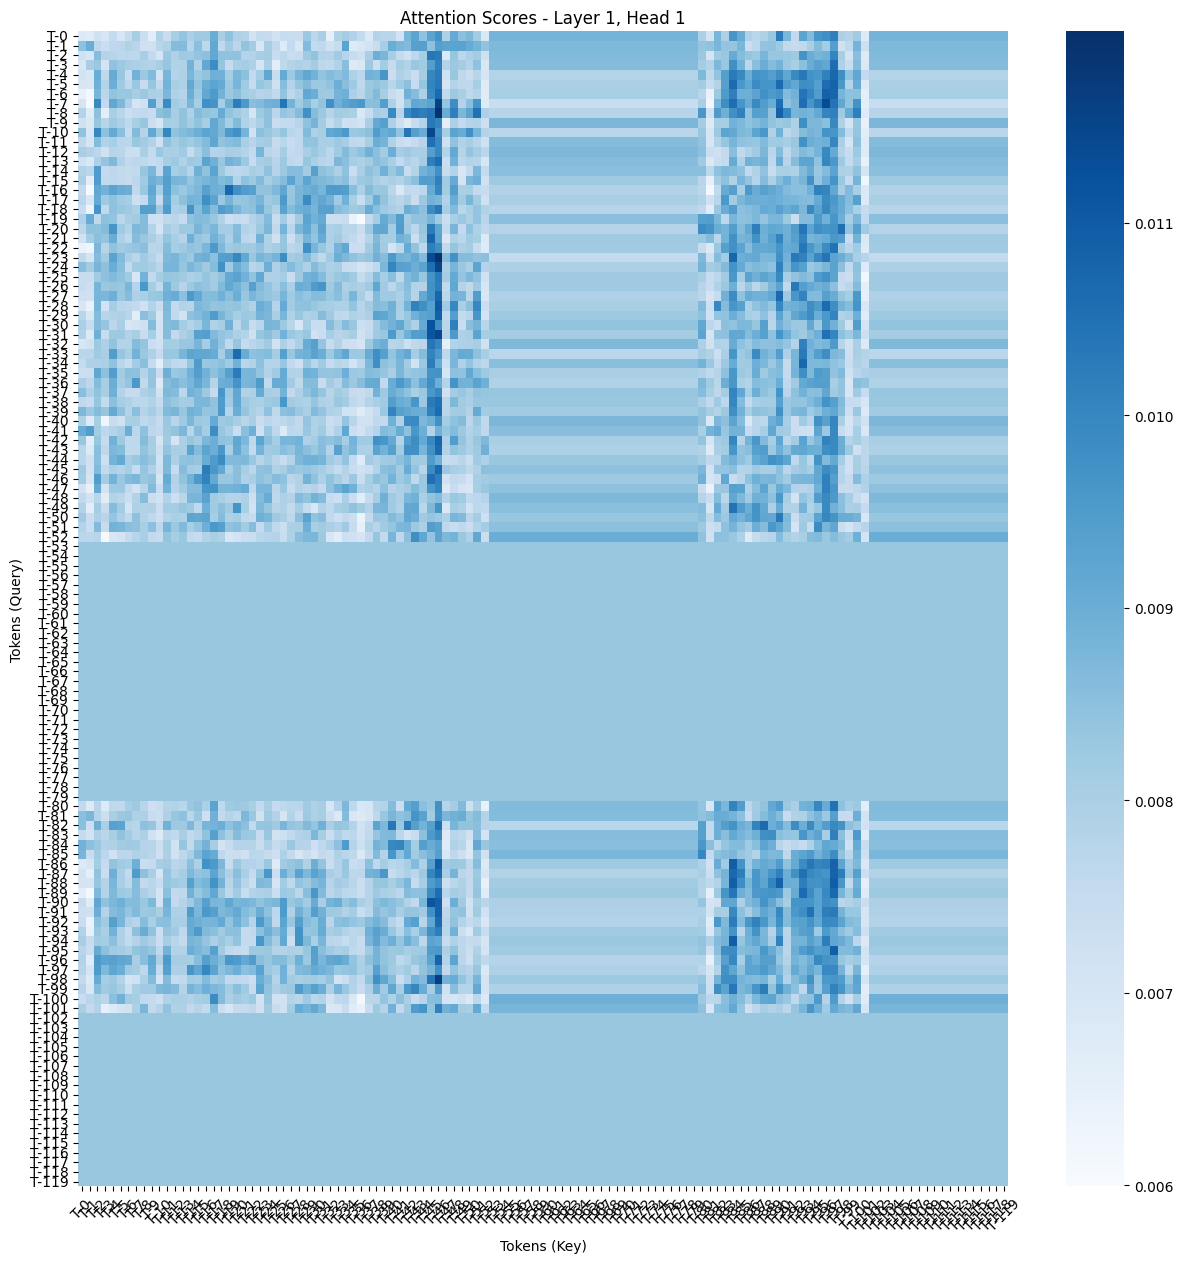

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None, return_attention=False):
        src2, attention_weights = self.self_attn(
            src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask, need_weights=True
        )
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        if return_attention:
            seq_len, batch_size = src.size(0), src.size(1)
            n_heads = self.self_attn.num_heads
            attention_weights = attention_weights.view(batch_size, 1, seq_len, seq_len)
            return src, attention_weights
        else:
            return src

class CustomTransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(CustomTransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.num_layers = num_layers

    def forward(self, src, src_mask=None, src_key_padding_mask=None, return_attention=False):
        attention_weights_list = []
        for layer in self.layers:
            if return_attention:
                src, attention_weights = layer(
                    src, src_mask=src_mask, src_key_padding_mask=src_key_padding_mask, return_attention=True
                )
                attention_weights_list.append(attention_weights)
            else:
                src = layer(src, src_mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        if return_attention:
            return src, attention_weights_list
        else:
            return src

class TextTransformerClassifier(nn.Module):
    def __init__(self, text_embedding_dim, hidden_dim, nhead, num_layers, output_dim):
        super(TextTransformerClassifier, self).__init__()
        custom_encoder_layer = CustomTransformerEncoderLayer(d_model=text_embedding_dim, nhead=nhead)
        self.text_transformer = CustomTransformerEncoder(custom_encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(text_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text_embeddings, audio_embeddings=None, return_attention=False):
        if text_embeddings is None:
            raise ValueError("Text embeddings cannot be None for the TextTransformerClassifier.")
        text_embeddings = text_embeddings.transpose(0, 1)
        if return_attention:
            text_out, attention_weights = self.text_transformer(
                text_embeddings, return_attention=True
            )
        else:
            text_out = self.text_transformer(text_embeddings)
            attention_weights = None
        text_out = torch.mean(text_out.transpose(0, 1), dim=1)
        text_out = F.relu(self.fc1(text_out))
        output = self.fc2(text_out)
        if return_attention:
            return output, attention_weights
        else:
            return output

def plot_attention(tokens, attention_scores, layer_idx=0, head_idx=0, batch_idx=0):
    attention_matrix = attention_scores[layer_idx][batch_idx, head_idx].detach().cpu().numpy()
    token_count = len(tokens)
    if attention_matrix.shape != (token_count, token_count):
        raise ValueError(f"Attention matrix size {attention_matrix.shape} does not match token count {token_count}.")

    print(f"Attention matrix shape: {attention_matrix.shape}")
    plt.figure(figsize=(15, 15))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="Blues", cbar=True)
    plt.title(f"Attention Scores - Layer {layer_idx + 1}, Head {head_idx + 1}")
    plt.xlabel("Tokens (Key)")
    plt.ylabel("Tokens (Query)")
    plt.xticks(rotation=45)
    plt.show()




# Dataset and Dataloader
dataset = TextOnlyDataset(text_embs_array, labels_array)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example usage
text_embedding_dim = text_embs_array.shape[-1]
hidden_dim = 128
output_dim = 1
nhead = 8
num_layers = 2
model = TextTransformerClassifier(text_embedding_dim, hidden_dim, nhead, num_layers, output_dim=1)

# Load a batch from the dataloader
batch = next(iter(dataloader))
text_embeddings = batch['text_embedding']  # Shape: (batch_size, seq_len, embed_dim)
labels = batch['label']  # Labels for the batch

# Ensure tokens match the sequence length for visualization
seq_len = text_embeddings.shape[1]
tokens = [f"T-{i}" for i in range(seq_len)]  # Example tokens

# Run the model with attention
model.eval()
with torch.no_grad():
    output, attention_scores = model(text_embeddings, return_attention=True)

# Visualize attention for the first layer, first head, first sequence in the batch
plot_attention(tokens, attention_scores, layer_idx=0, head_idx=0, batch_idx=0)